In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
map_size = [0, 100, 0, 100] # min x, max x, min y, max y

# Drone Position
num_agents = 2
x1 = [10, 10]
x2 = [10, 80]
x3 = [90, 20]
x4 = [90, 90]
coverage_position = {}
coverage_position['0'] = x1
coverage_position['1'] = x2
coverage_position['2'] = x3
coverage_position['3'] = x4
min_vel = 1
max_vel = 5 # Maximum velocity in which drone can move

# Charge Station
x_charge = [0, 0]
charging = None # If any of agents assigned, update charging into index number of agent [0, 1, 2, 3]

# Energy constraints
max_energy_level = 100 # Max energy level
charge_energy_level = 50 # Energy level in which charge request is sent
discharge_rate_at_min_vel = 1
discharge_rate_per_vel = 0.25
charge_rate = 5 # Charge rate of drone

In [3]:
def discharge_rate(drone_velocity):
    return discharge_rate_at_min_vel + drone_velocity*discharge_rate_per_vel

In [4]:
def distance(a, b):
    return np.sqrt((b[0]-a[0])**2 + (b[1]-a[1])**2)

In [5]:
def charge_log_check(current, charge_log_list):
    for i in range(len(charge_log_list)):
        temp = charge_log_list[i]
        if current[0] == charge_log_list[0] and current[1] == charge_log_list[1]:
            return True
    return False

In [6]:
class Agent:
    def __init__(self, x, y, energy_level):
        self.x = x
        self.y = y
        self.energy_level = energy_level
        self.energy_threshold = 100
        self.mode = 1
        self.charge_requested = False
        self.position_log = [[self.x, self.y]]
        self.energy_log = [self.energy_level]
        
    def guard_condition(self):
        # Trigger Mode 1 Guard condition
        if self.energy_level <= charge_energy_level and self.mode == 1:
            self.mode = 2
        elif distance([self.x, self.y], x_charge) <= 1 and self.mode == 2:
            self.mode = 3
        elif np.abs(self.energy_level-self.energy_threshold) <= charge_rate and self.mode == 3 and distance([self.x, self.y], x_charge) <= 1:
            self.mode = 1

In [7]:
class ChargingStation:
    def __init__(self, x, y):
        self.x = x_charge[0]
        self.y = x_charge[1]
        self.agent_charging = None
        self.time_charge_finished = None

In [8]:
agent_index_to_check = 0

In [ ]:
# 1. Drones dispatched from charge station at [0, 0] to its mission area (x1, x2, x3, x4)
# 1.1 While moving, drones use up their energy (discharge_rate)
# 2. When energy level reach recharge state (Mode 2), drones return to home port
t_vec = np.linspace(0, 1000, 1001)# Time Vector

# Initialize
charging_station = ChargingStation(x_charge[0], x_charge[1])
agent1 = Agent(x_charge[0], x_charge[1], 100)
agent2 = Agent(x_charge[0], x_charge[1], 100)
agent3 = Agent(x_charge[0], x_charge[1], 100)
agent4 = Agent(x_charge[0], x_charge[1], 100)
agent = {}
agent['0'] = agent1
agent['1'] = agent2
agent['2'] = agent3
agent['3'] = agent4
dist_threshold = 1
agent_indices = [0, 1, 2, 3]
charge_request_time = []
charge_request_time_log = []


dt = t_vec[2]-t_vec[1]/2
for t in t_vec:
    # At each time frame
    for agent_index in range(num_agents):
        # For each agenti
        # 1. Check Current Mode
        # 2. Update Position & Energy Level
        # 3. Check Guard Condition
        # 4. Update Mode

        # Check Current Mode
        current_agent = agent[str(agent_index)]
        current_mode = current_agent.mode
        current_position = [current_agent.x, current_agent.y]
        current_energy = current_agent.energy_level

        if agent_index == agent_index_to_check:
            print('----------------------')
            print('t: '+str(t))
            print('Current Position: ' + str([current_agent.x, current_agent.y]))
            print('Current Energy: ' + str(current_agent.energy_level))
            print('Mode: '+str(current_mode))

        # Update Position & Energy Level
        if current_mode == 1:
            # Mode 1: Perform Mission
            target_position = coverage_position[str(agent_index)]
            dist_to_target = distance(target_position, current_position)

            if agent_index == agent_index_to_check:
                print('target: ' + str(target_position))
                print('distnace: ' + str(dist_to_target))

            # Case 1: If not near mission area
            if np.abs(dist_to_target) > dist_threshold:
                # Position Update
                heading = np.arctan2([target_position[1]-current_position[1]], [target_position[0]-current_position[0]])
                new_x = current_position[0] + max_vel*np.cos(heading[0])*dt
                new_y = current_position[1] + max_vel*np.sin(heading[0])*dt
                current_agent.x = new_x
                current_agent.y = new_y

                if agent_index == agent_index_to_check:
                    print('Heading: ' + str(np.rad2deg(heading[0])))

                # Energy Update
                current_agent.energy_level = current_energy - discharge_rate(max_vel)*dt
            # Case 2: If already perfomring mission:
            else:
                current_agent.energy_level = current_energy - discharge_rate(0)*dt
        
        elif current_mode == 2:
            # First-Come First-Serve
            charge_request_instance = t
            if current_agent.charge_requested == False:
                current_log = [str(agent_index), t]
                charge_request_time.append(current_log)
                charge_request_time_log.append(current_log)
                current_agent.charge_requested = True

            target_position = x_charge
            dist_to_target = distance(target_position, current_position)

            if agent_index == agent_index_to_check:
                print('target: ' + str(target_position))
                print('distnace: ' + str(dist_to_target))
                print('Agent charging ' + str(charging_station.agent_charging))
            
            # If no other agent is charging akak if no previous log time,
            # Move to charge station at max vel
            
            if charging_station.agent_charging == None:
                # If no other agent is charging:
                charging_station.agent_charging = agent_index

                # Estimate time to finish charging
                time_to_charge_station = dist_to_target/max_vel
                energy_left_when_arrived = time_to_charge_station*discharge_rate(max_vel)
                time_to_charge_energy = (current_agent.energy_threshold - energy_left_when_arrived) / charge_rate
                charging_station.time_charge_finished = t + time_to_charge_station + time_to_charge_energy
                
                # print('current time: ' + str(t))
                # print('time to reach station: ' + str(time_to_charge_station))
                # print('energy left when arrived: ' + str(energy_left_when_arrived))
                # print('time to charge to full: ' + str(time_to_charge_energy))
                # print('time which station finished charging: ' + str(charging_station.time_charge_finished))


            if charging_station.agent_charging == agent_index:
                # Move to charge station at max speed
                heading = np.arctan2([target_position[1]-current_position[1]], [target_position[0]-current_position[0]])
                new_x = current_position[0] + max_vel*np.cos(heading[0])*dt
                new_y = current_position[1] + max_vel*np.sin(heading[0])*dt
                current_agent.x = new_x
                current_agent.y = new_y

                # Energy Update
                current_agent.energy_level = current_agent.energy_level - discharge_rate(max_vel)*dt
            else:
                # TODO:
                # If other agent is charging, slow down to arrive at exact moment
                pass
        else:
            # Mode 3
            # First remove current charge time from charge_request_time
            charge_request_time = charge_request_time[1:]

            # Update energy level by charging
            current_agent.energy_level += charge_rate

            if agent_index == agent_index_to_check:
                print('Energy Level: ' + str(current_agent.energy_level))
                
        # Check Guard Condition & Update Mode
        current_agent.guard_condition()
        if agent_index == agent_index_to_check:
            print('Mode: '+str(current_agent.mode))

        # Update Agent Log
        current_agent.position_log.append([current_agent.x, current_agent.y])
        current_agent.energy_log.append(current_agent.energy_level)
        
    if t == 45:
        print('Charge Requests: '+str(charge_request_time))
        print('Agent currently charging: Agent ' + str(charging_station.agent_charging))
        adfasfdasf

----------------------
t: 0.0
Current Position: [0, 0]
Current Energy: 100
Mode: 1
target: [10, 10]
distnace: 14.142135623730951
Heading: 45.0
Mode: 1
----------------------
t: 1.0
Current Position: [5.303300858899107, 5.303300858899106]
Current Energy: 96.625
Mode: 1
target: [10, 10]
distnace: 6.642135623730951
Heading: 45.00000000000001
Mode: 1
----------------------
t: 2.0
Current Position: [10.606601717798213, 10.606601717798213]
Current Energy: 93.25
Mode: 1
target: [10, 10]
distnace: 0.8578643762690501
Mode: 1
----------------------
t: 3.0
Current Position: [10.606601717798213, 10.606601717798213]
Current Energy: 91.75
Mode: 1
target: [10, 10]
distnace: 0.8578643762690501
Mode: 1
----------------------
t: 4.0
Current Position: [10.606601717798213, 10.606601717798213]
Current Energy: 90.25
Mode: 1
target: [10, 10]
distnace: 0.8578643762690501
Mode: 1
----------------------
t: 5.0
Current Position: [10.606601717798213, 10.606601717798213]
Current Energy: 88.75
Mode: 1
target: [10, 

NameError: name 'adfasfdasf' is not defined

Text(0, 0.5, 'Energy Level (Unit)')

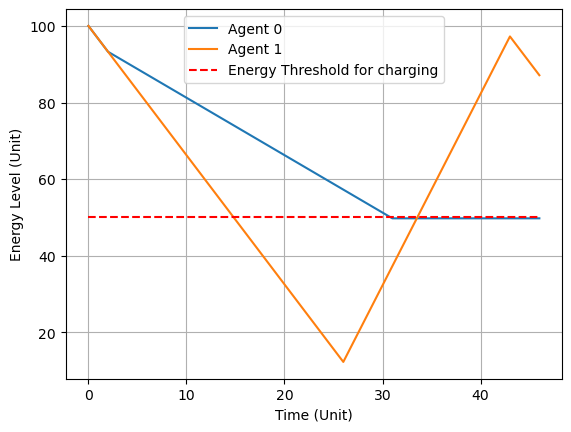

In [11]:
# Time over Energy Plot for Agents
fig = plt.figure()
for i in range(num_agents):
    agent_to_check = agent[str(i)]
    plt.plot(t_vec[:len(agent_to_check.energy_log)], agent_to_check.energy_log, '-', label='Agent '+str(i))
plt.plot([t_vec[0], t_vec[len(agent_to_check.energy_log)-1]], [charge_energy_level, charge_energy_level], '--r', label='Energy Threshold for charging')
plt.legend()
plt.grid()
plt.xlabel('Time (Unit)')
plt.ylabel('Energy Level (Unit)')